# Multiple Project Operations

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import RasCmdr, RasExamples, RasPlan, RasPrj, init_ras_project, ras

# Additional imports
import os
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import shutil

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Prerequisites

Before running this notebook, ensure you have:

1. **ras-commander installed**: `pip install ras-commander`
2. **Python 3.10+**: Check with `python --version`
3. **HEC-RAS 6.3+**: Required for plan execution
4. **Disk Space**: ~2 GB (example projects + compute folders + results)
5. **CPU Cores**: 2+ recommended for parallel execution

### What You'll Learn

This notebook demonstrates **advanced multi-project workflows** - a powerful pattern for comparative analysis:

- **Parallel Project Management**: Initialize and track multiple HEC-RAS projects simultaneously
- **Context Discipline**: Pass `ras_object` parameter to avoid the global `ras` trap (see `.claude/rules/python/ras-commander-patterns.md`)
- **Concurrent Execution**: Run plans from different projects in parallel
- **Result Comparison**: Analyze differences between project configurations

### Related Notebooks

- **101_project_initialization.ipynb** - Learn single-project initialization first
- **113_parallel_execution.ipynb** - Parallel execution within one project
- **103_plan_and_geometry_operations.ipynb** - Plan cloning techniques

### Critical Pattern: The ras_object Parameter

**THE MOST IMPORTANT CONCEPT IN THIS NOTEBOOK**:

When creating local `ras` objects (e.g., `bald_eagle_ras = RasPrj()`), you MUST pass them to ALL downstream function calls via the `ras_object` parameter.

**Why?** Most ras-commander functions accept optional `ras_object` parameter. If not provided, they fall back to the global `ras` object - causing file path resolution errors when working with multiple projects.

```python
# ✅ CORRECT: Pass ras_object to every call
RasPlan.clone_plan("01", new_plan_shortid="demo", ras_object=bald_eagle_ras)
RasCmdr.compute_plan("demo", ras_object=bald_eagle_ras)

# ❌ WRONG: Missing ras_object - uses global ras!
RasPlan.clone_plan("01", new_plan_shortid="demo")  # Will look in wrong project!
```

See `.claude/rules/python/ras-commander-patterns.md` for complete details.

## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

In [3]:
# Check system resources
cpu_count = psutil.cpu_count(logical=True)
physical_cpu_count = psutil.cpu_count(logical=False)
available_memory_gb = psutil.virtual_memory().available / (1024**3)

print(f"System Resources:")
print(f"- {physical_cpu_count} physical CPU cores ({cpu_count} logical cores)")
print(f"- {available_memory_gb:.1f} GB available memory")
print(f"For multiple HEC-RAS projects, a good rule of thumb is:")
print(f"- Assign 2-4 cores per project")
print(f"- Allocate at least 2-4 GB of RAM per project")
print(f"Based on your system, you could reasonably run {min(physical_cpu_count//2, int(available_memory_gb//3))} projects simultaneously.")

System Resources:
- 8 physical CPU cores (8 logical cores)
- 18.7 GB available memory
For multiple HEC-RAS projects, a good rule of thumb is:
- Assign 2-4 cores per project
- Allocate at least 2-4 GB of RAM per project
Based on your system, you could reasonably run 4 projects simultaneously.


## Understanding Multiple RAS Project Management

When working with multiple HEC-RAS projects in RAS Commander, there are two important concepts to understand:

1. **The Global 'ras' Object**: By default, RAS Commander maintains a global `ras` object that represents the currently active project. This is convenient for simple scripts.

2. **Custom RAS Objects**: For multiple projects, you'll create separate RAS objects for each project. These custom objects store project-specific data and are passed to RAS Commander functions using the `ras_object` parameter.

### Best Practices for Multiple Project Management

- **Name Your Objects Clearly**: Use descriptive variable names for your RAS objects (e.g., `bald_eagle_ras`, `muncie_ras`)
- **Be Consistent**: Always pass the appropriate RAS object to functions when working with multiple projects
- **Avoid Using Global 'ras'**: When working with multiple projects, avoid using the global `ras` object to prevent confusion
- **Separate Compute Folders**: Use separate computation folders for each project
- **Manage Resources**: Be mindful of CPU and memory usage when running multiple projects in parallel

## Downloading and Extracting Example HEC-RAS Projects

We'll use the `RasExamples` class to download and extract two example HEC-RAS projects: "Balde Eagle Creek" and "Muncie".

In [4]:
# Extract the example projects using suffix parameter
extracted_paths = RasExamples.extract_project(
    ["Balde Eagle Creek", "Muncie"],
    suffix="04"  # Uses standardized suffix parameter
)
print(f"Extracted projects to:")
for path in extracted_paths:
    print(f"- {path}")

# Define project paths
bald_eagle_path = extracted_paths[0]  # First project (Balde Eagle Creek)
muncie_path = extracted_paths[1]      # Second project (Muncie)
examples_dir = extracted_paths[0].parent

# Define computation output folders
bald_eagle_compute_folder = examples_dir / "compute_bald_eagle"
muncie_compute_folder = examples_dir / "compute_muncie"

# Verify the paths exist
print(f"\nBald Eagle Creek project exists: {bald_eagle_path.exists()}")
print(f"Muncie project exists: {muncie_path.exists()}")
print(f"Computation folders will be created at:")
print(f"- {bald_eagle_compute_folder}")
print(f"- {muncie_compute_folder}")

2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek' as 'Balde Eagle Creek_04'
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Folder 'Balde Eagle Creek_04' already exists. Deleting existing folder...
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Existing folder 'Balde Eagle Creek_04' has been deleted.
2026-01-11 20:43:55 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\exa

Extracted projects to:
- C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04
- C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_04

Bald Eagle Creek project exists: True
Muncie project exists: True
Computation folders will be created at:
- C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle
- C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_muncie


## Step 1: Initialize Multiple Projects

Let's initialize both HEC-RAS projects. Instead of using the global `ras` object, we'll create separate RAS objects for each project.

In [5]:
# Initialize both projects with their own RAS objects
bald_eagle_ras = RasPrj()
init_ras_project(bald_eagle_path, RAS_VERSION, ras_object=bald_eagle_ras)
print(f"Initialized Bald Eagle Creek project: {bald_eagle_ras.project_name}")

muncie_ras = RasPrj()
init_ras_project(muncie_path, RAS_VERSION, ras_object=muncie_ras)
print(f"Initialized Muncie project: {muncie_ras.project_name}")

# Display available plans in each project
print("\nAvailable plans in Bald Eagle Creek project:")
display.display(bald_eagle_ras.plan_df)

print("\nAvailable plans in Muncie project:")
display.display(muncie_ras.plan_df)

2026-01-11 20:43:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.rasmap
2026-01-11 20:43:56 - ras_commander.RasPrj - INFO - Updated results_df with 2 plan(s)
2026-01-11 20:43:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_04\Muncie.rasmap
2026-01-11 20:43:56 - ras_commander.RasPrj - INFO - Updated results_df with 3 plan(s)


Initialized Bald Eagle Creek project: BaldEagle
Initialized Muncie project: Muncie

Available plans in Bald Eagle Creek project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,None,dss,2,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,None,dss,1,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Steady



Available plans in Muncie project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,1,NaN,NaN,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,1,Pardiso (Direct),2D Interior Area,None,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,1,Pardiso (Direct),2D Interior Area,None,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady


## Step 2: Clone Plans in Each Project

Now, let's clone a plan in each project, giving them custom short identifiers. This demonstrates how to perform operations on multiple projects independently.

In [6]:
# Clone plans with custom short identifiers
new_bald_eagle_plan = RasPlan.clone_plan("01", new_plan_shortid="MultiProjDemo", ras_object=bald_eagle_ras)
print(f"Created new plan {new_bald_eagle_plan} in Bald Eagle Creek project")

new_muncie_plan = RasPlan.clone_plan("01", new_plan_shortid="MultiProjDemo", ras_object=muncie_ras)
print(f"Created new plan {new_muncie_plan} in Muncie project")

# Display the updated plan dataframes
print("\nUpdated plans in Bald Eagle Creek project:")
bald_eagle_ras.plan_df = bald_eagle_ras.get_plan_entries()  # Refresh the plan dataframe
display.display(bald_eagle_ras.plan_df)

print("\nUpdated plans in Muncie project:")
muncie_ras.plan_df = muncie_ras.get_plan_entries()  # Refresh the plan dataframe
display.display(muncie_ras.plan_df)

2026-01-11 20:43:56 - ras_commander.RasUtils - INFO - File cloned from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.p01 to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.p03
2026-01-11 20:43:56 - ras_commander.RasUtils - INFO - Successfully updated file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.p03
2026-01-11 20:43:56 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 03
2026-01-11 20:43:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.rasmap
2026-01-11 20:43:56 - ras_commander.RasPrj - INFO - Updated results_df with 3 plan(s)
2026-01-11 20:43:56 - ras_commander.RasUtils - INFO -

Created new plan 03 in Bald Eagle Creek project
Created new plan 02 in Muncie project

Updated plans in Bald Eagle Creek project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,0.0,None,dss,2,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,NaN,None,dss,1,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
2,03,02,01,Unsteady with Bridges and Dam,5.00,MultiProjDemo,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,0.0,None,dss,2,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...



Updated plans in Muncie project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,01,01,Unsteady Multi 9-SA run,5.00,9-SAs,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,dss,1,NaN,NaN,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,03,01,02,Unsteady Run with 2D 50ft Grid,5.10,2D 50ft Grid,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,-1,...,dss,1,Pardiso (Direct),2D Interior Area,None,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
2,04,01,04,Unsteady Run with 2D 50ft User n Value R,5.10,50ft User n Regions,"02JAN1900,0000,02JAN1900,2400",10SEC,5MIN,1,...,dss,1,Pardiso (Direct),2D Interior Area,None,04,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
3,02,01,01,Unsteady Multi 9-SA run,5.00,MultiProjDemo,"02JAN1900,0000,02JAN1900,2400",15SEC,5MIN,1,...,dss,1,NaN,NaN,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


## Step 3: Configure Plans for Both Projects

Let's configure the plans for both projects, setting geometry, number of cores, and other parameters. This demonstrates how to customize plans for different projects using the same code structure.

In [7]:
# Configure the Bald Eagle Creek plan
print("Configuring Bald Eagle Creek plan:")
RasPlan.set_geom(new_bald_eagle_plan, "01", ras_object=bald_eagle_ras)
RasPlan.set_num_cores(new_bald_eagle_plan, 2, ras_object=bald_eagle_ras)

# Update description and intervals
description = "Multi-project demonstration plan\nBald Eagle Creek project\nConfigured for parallel execution"
RasPlan.update_plan_description(new_bald_eagle_plan, description, ras_object=bald_eagle_ras)
RasPlan.update_plan_intervals(
    new_bald_eagle_plan, 
    computation_interval="10SEC", 
    output_interval="5MIN", 
    ras_object=bald_eagle_ras
)
print("Successfully configured Bald Eagle Creek plan")

# Configure the Muncie plan
print("\nConfiguring Muncie plan:")
RasPlan.set_geom(new_muncie_plan, "01", ras_object=muncie_ras)
RasPlan.set_num_cores(new_muncie_plan, 2, ras_object=muncie_ras)

# Update description and intervals
description = "Multi-project demonstration plan\nMuncie project\nConfigured for parallel execution"
RasPlan.update_plan_description(new_muncie_plan, description, ras_object=muncie_ras)
RasPlan.update_plan_intervals(
    new_muncie_plan, 
    computation_interval="10SEC", 
    output_interval="5MIN", 
    ras_object=muncie_ras
)
print("Successfully configured Muncie plan")

Configuring Bald Eagle Creek plan:


2026-01-11 20:43:56 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g01 for plan 03
2026-01-11 20:43:56 - ras_commander.RasPlan - INFO - Geometry for plan 03 set to 01
2026-01-11 20:43:56 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.p03
2026-01-11 20:43:56 - ras_commander.RasUtils - INFO - Successfully updated file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.p03
2026-01-11 20:43:56 - ras_commander.RasPlan - INFO - Successfully updated intervals in plan file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04\BaldEagle.p03
2026-01-11 20:43:56 - ras_commander.RasPlan - INFO - Updated Geom File in plan file to g01 for plan 02
2026-01-11 20:43:56 - ras_commander.RasPlan - INFO - Geometry 

Successfully configured Bald Eagle Creek plan

Configuring Muncie plan:
Successfully configured Muncie plan


## Step 4: Create Compute Folders for Both Projects

Now, let's create separate compute folders for each project. This allows us to run the computations separately and in parallel.

In [8]:
# Create compute folders or clean them if they already exist
# Note: Only cleaning compute folders, not the source projects
for folder in [bald_eagle_compute_folder, muncie_compute_folder]:
    # Safety check: only delete folders that are within examples_dir
    if folder.exists() and examples_dir in folder.parents:
        shutil.rmtree(folder)
        print(f"Removed existing compute folder: {folder}")
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Created compute folder: {folder}")

Removed existing compute folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle
Created compute folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle
Removed existing compute folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_muncie
Created compute folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_muncie


## Step 5: Define Project Execution Function

Let's define a function to execute plans for each project, which we can run in parallel. This function will handle plan execution, timing, and provide detailed status updates.

In [9]:
def execute_plan(plan_number, ras_object, compute_folder, project_name):
    """
    Execute a HEC-RAS plan and return detailed information about the execution.
    
    Args:
        plan_number (str): The plan number to execute
        ras_object: The RAS project object
        compute_folder (Path): Folder where computation will be performed
        project_name (str): A descriptive name for the project
        
    Returns:
        dict: Detailed information about the execution
    """
    print(f"Starting execution of plan {plan_number} for {project_name}...")
    
    # Record start time
    start_time = time.time()
    
    # Execute the plan in the compute folder
    success = RasCmdr.compute_plan(
        plan_number=plan_number, 
        ras_object=ras_object, 
        dest_folder=compute_folder,
        clear_geompre=True
    )
    
    # Record end time and calculate duration
    end_time = time.time()
    duration = end_time - start_time
    
    # Determine if results were created
    result_path = None
    result_size = None
    
    try:
        # Initialize a temporary RAS object in the compute folder to check results
        compute_ras = init_ras_project(compute_folder, ras_object.ras_exe_path)
        result_path = RasPlan.get_results_path(plan_number, ras_object=compute_ras)
        
        if result_path:
            result_file = Path(result_path)
            if result_file.exists():
                result_size = result_file.stat().st_size / (1024 * 1024)  # Size in MB
    except Exception as e:
        print(f"Error checking results for {project_name}: {e}")
    
    # Build result information
    result_info = {
        "project_name": project_name,
        "plan_number": plan_number,
        "success": success,
        "duration": duration,
        "compute_folder": str(compute_folder),
        "result_path": str(result_path) if result_path else None,
        "result_size_mb": result_size,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    
    print(f"Completed execution of plan {plan_number} for {project_name} in {duration:.2f} seconds")
    return result_info

### Verification: Parallel Execution

**Success Criteria**:
- ✓ Both projects execute without errors
- ✓ HDF files created in correct compute folders
- ✓ Execution times logged for performance comparison
- ✓ `results` list contains two dictionaries with project metadata

**What to Check**:
```python
# Verify both executions succeeded
assert len(results) == 2, "Expected 2 project results"

for result in results:
    hdf_file = Path(result['hdf_path'])
    assert hdf_file.exists(), f"HDF file not created: {hdf_file}"
    print(f"✓ {result['project_name']}: {hdf_file.stat().st_size / 1e6:.1f} MB")
```

**Visual Inspection**:
1. Open both projects in HEC-RAS GUI
2. Load plans created by cloning ("MultiProjDemo" plan)
3. View results in RAS Mapper to confirm valid outputs

**Performance Analysis**:
The parallel execution should complete in approximately the time of the longest plan, not the sum:
- Sequential: `time_project1 + time_project2`
- Parallel: `max(time_project1, time_project2)`

### Audit Trail

Export execution metadata for documentation:
```python
import pandas as pd

audit_df = pd.DataFrame(results)
audit_df.to_csv('multiple_project_execution_audit.csv', index=False)
print("Audit trail saved to: multiple_project_execution_audit.csv")
```

This audit trail documents:
- Which projects were executed
- When execution occurred
- How long each took
- Where results are stored

## Step 6: Execute Plans for Both Projects in Parallel

Now, let's run both projects in parallel using a `ThreadPoolExecutor`. This allows us to utilize our system resources efficiently.

In [10]:
print("Executing plans for both projects in parallel...")
print("This may take several minutes...")

# Define the execution tasks
execution_tasks = [
    (new_bald_eagle_plan, bald_eagle_ras, bald_eagle_compute_folder, "Bald Eagle Creek"),
    (new_muncie_plan, muncie_ras, muncie_compute_folder, "Muncie")
]

results = []

# Execute the plans in parallel using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [
        executor.submit(execute_plan, *task)
        for task in execution_tasks
    ]
    
    # Collect results as they complete
    for future in as_completed(futures):
        try:
            result = future.result()
            results.append(result)
        except Exception as e:
            print(f"Execution error: {e}")

print("\nAll executions complete!")

2026-01-11 20:43:56 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_04
2026-01-11 20:43:56 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Muncie_04


Executing plans for both projects in parallel...
This may take several minutes...
Starting execution of plan 03 for Bald Eagle Creek...
Starting execution of plan 02 for Muncie...


2026-01-11 20:43:56 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle
2026-01-11 20:43:56 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle\BaldEagle.rasmap
2026-01-11 20:43:56 - ras_commander.RasPrj - INFO - Updated results_df with 3 plan(s)
2026-01-11 20:43:56 - ras_commander.geom.GeomPreprocessor - INFO - Clearing geometry preprocessor file for single plan: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle\BaldEagle.p03
2026-01-11 20:43:56 - ras_commander.geom.GeomPreprocessor - WARNING - No geometry preprocessor file found for: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle\BaldEagle.p03
2026-01

Completed execution of plan 02 for Muncie in 27.67 seconds


2026-01-11 20:46:29 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 03
2026-01-11 20:46:29 - ras_commander.RasCmdr - INFO - Total run time for plan 03: 153.24 seconds
2026-01-11 20:46:29 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle\BaldEagle.rasmap
2026-01-11 20:46:29 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle\BaldEagle.p03.hdf
2026-01-11 20:46:29 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\compute_bald_eagle\BaldEagle.p03.hdf
2026-01-11 20:46:29 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p03.hdf
2026-01-11 20:46:

Completed execution of plan 03 for Bald Eagle Creek in 153.30 seconds

All executions complete!


## Viewing Execution Summary with results_df

For multi-project operations, each RAS object has its own `results_df`. Note that the global `ras` object shows the last initialized project (Muncie in this case).

In [11]:
# Display results for both projects
print("Bald Eagle Creek Results:")
display.display(bald_eagle_ras.results_df[["plan_number", "plan_title", "completed", "has_errors"]])

print("\nMuncie Results:")
display.display(muncie_ras.results_df[["plan_number", "plan_title", "completed", "has_errors"]])

Bald Eagle Creek Results:


,plan_number,plan_title,completed,has_errors
0,01,Unsteady with Bridges and Dam,False,False
1,02,Steady Flow Run,False,False
2,03,Unsteady with Bridges and Dam,False,False



Muncie Results:


,plan_number,plan_title,completed,has_errors
0,01,Unsteady Multi 9-SA run,False,False
1,03,Unsteady Run with 2D 50ft Grid,False,False
2,04,Unsteady Run with 2D 50ft User n Value R,False,False
3,02,Unsteady Multi 9-SA run,False,False


## Step 7: Analyze Results

Let's analyze the results from both project executions, comparing execution times, result sizes, etc.

Execution Results Summary:


,project_name,plan_number,success,duration,result_size_mb
0,Muncie,02,True,27.667250,3.857895
1,Bald Eagle Creek,03,True,153.302519,11.529897


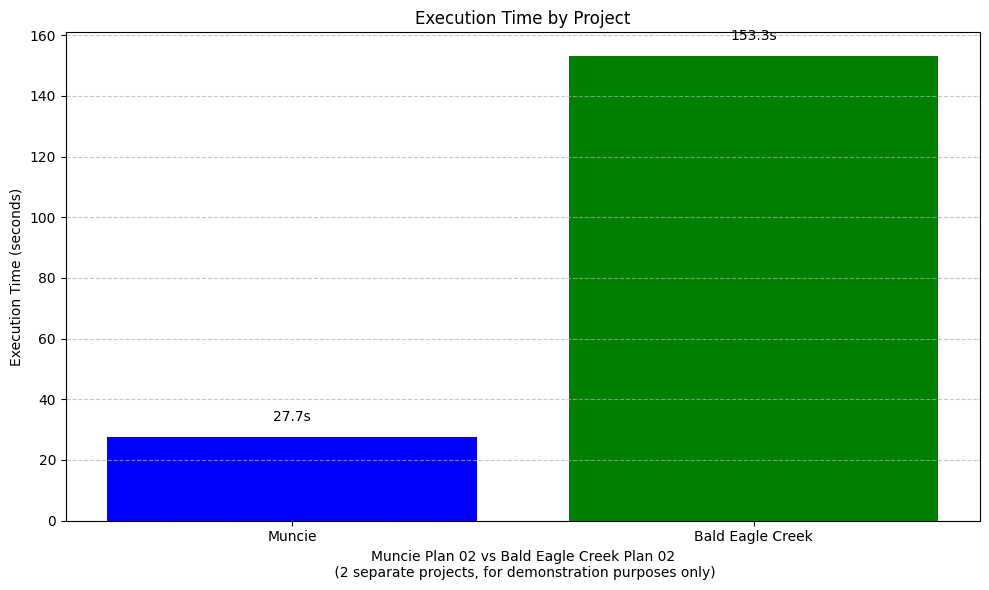

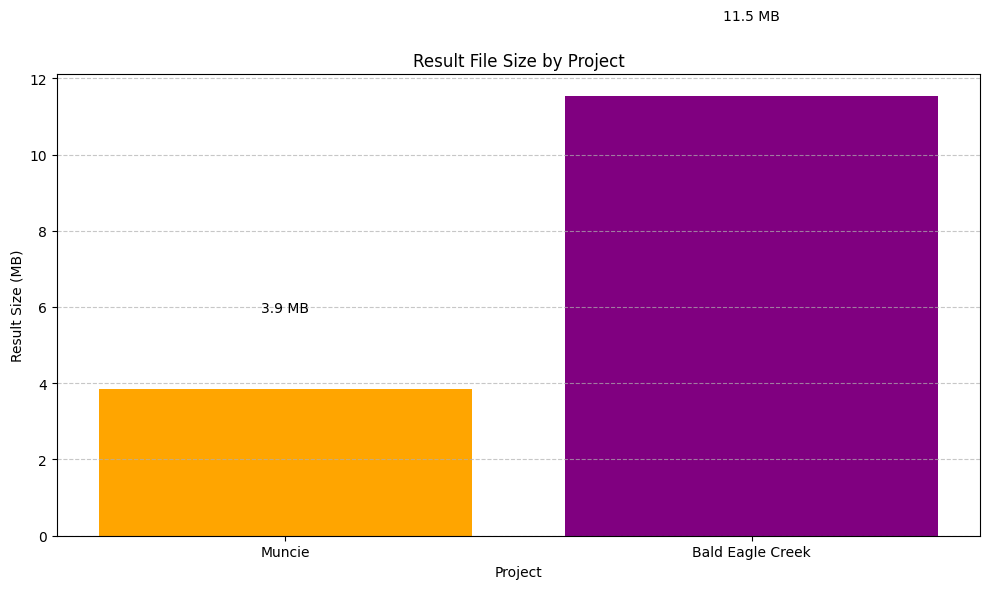

In [12]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results table
print("Execution Results Summary:")
display.display(results_df[['project_name', 'plan_number', 'success', 'duration', 'result_size_mb']])

# Create a bar chart for execution times
plt.figure(figsize=(10, 6))
plt.bar(results_df['project_name'], results_df['duration'], color=['blue', 'green'])
plt.title('Execution Time by Project')
plt.xlabel('Muncie Plan 02 vs Bald Eagle Creek Plan 02\n (2 separate projects, for demonstration purposes only)')
plt.ylabel('Execution Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add duration values on top of the bars
for i, duration in enumerate(results_df['duration']):
    plt.text(i, duration + 5, f"{duration:.1f}s", ha='center')

plt.tight_layout()
plt.show()

# If we have result sizes, create a chart for those as well
if results_df['result_size_mb'].notna().any():
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['project_name'], results_df['result_size_mb'], color=['orange', 'purple'])
    plt.title('Result File Size by Project')
    plt.xlabel('Project')
    plt.ylabel('Result Size (MB)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add size values on top of the bars
    for i, size in enumerate(results_df['result_size_mb']):
        if pd.notna(size):
            plt.text(i, size + 2, f"{size:.1f} MB", ha='center')
    
    plt.tight_layout()
    plt.show()

## Step 9: Compare Two HEC-RAS Projects

Let's create a utility function to compare the structures of the two HEC-RAS projects. This helps us understand the differences between the projects we're working with.

Project Structure Comparison:


,Project Name,Plan Count,Geometry Count,Flow Count,Unsteady Count
Bald Eagle Creek,BaldEagle,3,1,2,1
Muncie,Muncie,4,3,1,1


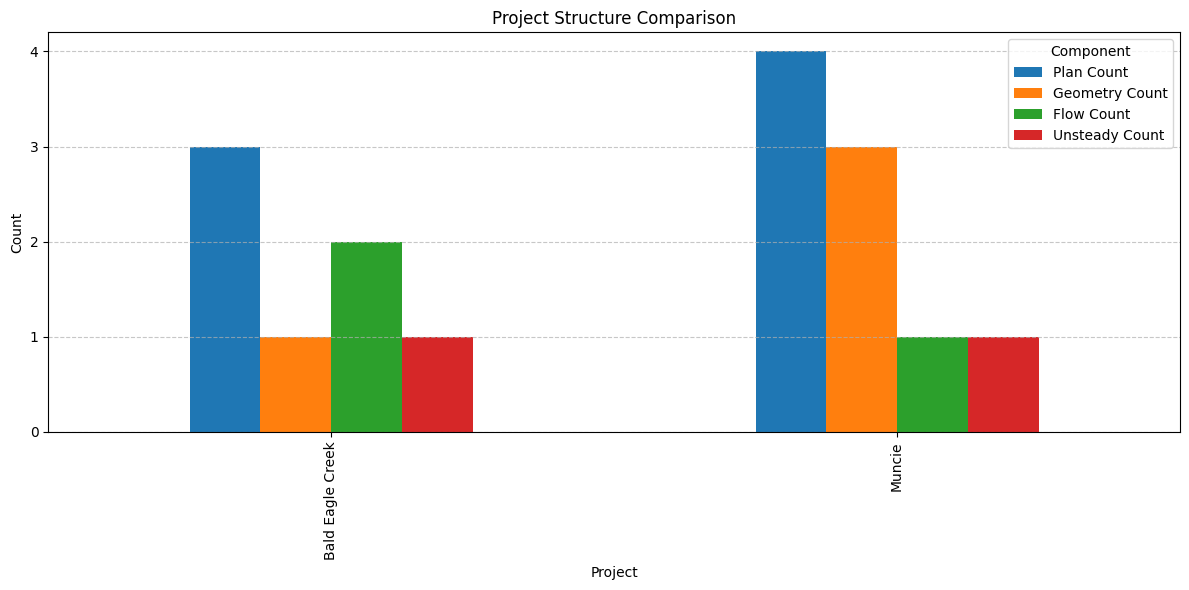

In [13]:
def compare_project_structures(ras_object1, name1, ras_object2, name2):
    """
    Compare the structures of two HEC-RAS projects and display differences.
    """
    # Refresh all dataframes to ensure we have the latest data
    ras_object1.plan_df = ras_object1.get_plan_entries()
    ras_object1.geom_df = ras_object1.get_geom_entries()
    ras_object1.flow_df = ras_object1.get_flow_entries()
    ras_object1.unsteady_df = ras_object1.get_unsteady_entries()
    
    ras_object2.plan_df = ras_object2.get_plan_entries()
    ras_object2.geom_df = ras_object2.get_geom_entries()
    ras_object2.flow_df = ras_object2.get_flow_entries()
    ras_object2.unsteady_df = ras_object2.get_unsteady_entries()
    
    # Create a comparison dictionary
    comparison = {
        'Project Name': [ras_object1.project_name, ras_object2.project_name],
        'Plan Count': [len(ras_object1.plan_df), len(ras_object2.plan_df)],
        'Geometry Count': [len(ras_object1.geom_df), len(ras_object2.geom_df)],
        'Flow Count': [len(ras_object1.flow_df), len(ras_object2.flow_df)],
        'Unsteady Count': [len(ras_object1.unsteady_df), len(ras_object2.unsteady_df)]
    }
    
    # Create a DataFrame for the comparison
    comparison_df = pd.DataFrame(comparison, index=[name1, name2])
    

    # Display the comparison
    print("Project Structure Comparison:")
    display.display(comparison_df)
    
    # Create a bar chart to visualize the comparison
    plt.figure(figsize=(12, 6))
    comparison_df.iloc[:, 1:].plot(kind='bar', ax=plt.gca())
    plt.title('Project Structure Comparison')
    plt.xlabel('Project')
    plt.ylabel('Count')
    plt.legend(title='Component')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to only show whole numbers (integers)
    ax = plt.gca()
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Compare the structures of the two projects
comparison_df = compare_project_structures(
    bald_eagle_ras, "Bald Eagle Creek", 
    muncie_ras, "Muncie"
)

-----

## This approach can also be used to programmatically compare 2 copies of the same project to ensure all of the plan parameters, boundary condition definitions, etc remained the same, and for other QAQC processes.

This will be shown in further examples in more detail.

-----

## Best Practices for Multiple Project Operations

### When to Use Multiple Projects

**Use Case 1: Comparative Analysis**
- Evaluate different modeling approaches
- Before/after scenarios (existing vs proposed conditions)
- Sensitivity analysis with different model parameters

**Use Case 2: Batch Processing**
- Process multiple watersheds with same workflow
- Apply calibration to multiple reaches
- Generate reports for multiple projects

**Use Case 3: Model Variants**
- Test different boundary conditions
- Compare 1D vs 2D approaches
- Evaluate bridge/culvert alternatives

### Critical Gotchas

**❌ Common Mistake: Missing ras_object Parameter**

```python
# Initialize two projects
project1_ras = RasPrj()
init_ras_project(project1_path, "6.6", ras_object=project1_ras)

project2_ras = RasPrj()
init_ras_project(project2_path, "6.6", ras_object=project2_ras)

# ❌ WRONG: Missing ras_object
new_plan = RasPlan.clone_plan("01", new_plan_shortid="test")
# ^ This will use the global ras object, not project1_ras!

# ✅ CORRECT: Always pass ras_object
new_plan = RasPlan.clone_plan("01", new_plan_shortid="test", ras_object=project1_ras)
```

**Symptom**: `FileNotFoundError` for files that should exist
**Root Cause**: Function looked in global `ras` project folder instead of specified project
**Fix**: Add `ras_object=your_ras_instance` to ALL function calls

See `.claude/rules/python/ras-commander-patterns.md` for complete documentation.

### HEC-RAS Documentation

- **User's Manual - Chapter 3**: Project management and file organization
  https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx
- **Technical Reference - Appendix A**: File format specifications

### LLM Forward: Multi-Project Review

Multiple project workflows benefit from structured comparison:

```python
def generate_project_comparison_report(ras_objects, names, output_file):
    # Generate comparative analysis report
    report = []

    for ras_obj, name in zip(ras_objects, names):
        report.append({
            'project': name,
            'num_plans': len(ras_obj.plan_df),
            'num_cross_sections': len(ras_obj.geom_df),  # Simplified
            'project_file': str(ras_obj.prj_file),
        })

    df = pd.DataFrame(report)
    df.to_csv(output_file, index=False)
    print(f"Comparison report saved: {output_file}")

    return df

# Usage
comparison = generate_project_comparison_report(
    [bald_eagle_ras, muncie_ras],
    ["Bald Eagle Creek", "Muncie"],
    "project_comparison.csv"
)
```

This enables:
- **Visual comparison**: Open CSV in Excel for review
- **Audit trail**: Document what was compared when
- **Reproducibility**: Re-run analysis from saved configuration

## Summary of Multiple Project Operations

In this notebook, we've demonstrated how to work with multiple HEC-RAS projects simultaneously using the RAS Commander library. We've covered the following key operations:

1. **Initializing Multiple Projects**: Creating separate RAS objects for different projects
2. **Independent Configuration**: Configuring plans with project-specific parameters
3. **Parallel Execution**: Running computations from different projects simultaneously
4. **Resource Management**: Organizing compute folders and tracking execution statistics
5. **Results Comparison**: Analyzing and comparing results from different projects
6. **Advanced Workflows**: Creating sensitivity plans and batch processing pipelines

### Key Concepts

When working with multiple HEC-RAS projects in RAS Commander, remember these key concepts:

- **Custom RAS Objects**: Create and use separate RAS objects for each project
- **Always Specify ras_object**: Use the `ras_object` parameter in all function calls
- **Separate Compute Folders**: Use separate folders for each project's computations
- **Resource Management**: Be mindful of CPU and memory usage when running in parallel
- **Project Tracking**: Keep track of which results belong to which project

### Multiple Project Applications

Working with multiple projects unlocks advanced applications such as:

1. **Model Comparison**: Compare results from different river systems
2. **Basin-wide Analysis**: Analyze connected river systems in parallel
3. **Parameter Sweep**: Test a range of parameters across multiple models
4. **Model Development**: Develop and test models simultaneously
5. **Batch Processing**: Process large sets of models in an automated pipeline

These capabilities make RAS Commander a powerful tool for large-scale hydraulic modeling and water resources management.